In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pylab as plt
from matplotlib import gridspec
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
import itertools
import pyccl as ccl
import os
import scipy.stats as st

%matplotlib inline

In [3]:
class Cosmo:
    def __init__(self,Omega_ch2=0.1, Omega_bh2=0.023, AS=None, S8=None,
                 Omega_nu_h2=0., H0=70, ns=0.97, w0=-1, alpha=0.45, 
                 matter_power_spectrum = 'halofit'):
        
        self._matter_power_spectrum =  matter_power_spectrum
        self.update_cosmology(Omega_ch2=Omega_ch2, Omega_bh2=Omega_bh2,
                              AS=AS, S8=S8, alpha=alpha,
                              Omega_nu_h2=Omega_nu_h2,
                              H0=H0, ns=ns, w0=w0)
        
    def update_cosmology(self, Omega_ch2=0.1, Omega_bh2=0.023, AS=None, S8=None,
                         Omega_nu_h2=1e-3, H0=70, ns=0.97, w0=-1, alpha=0.45):

        self.Omega_ch2 = Omega_ch2
        self.Omega_bh2 = Omega_bh2
        self.H0 = H0
        self._h = self.H0 / 100.

        self._Omega_b = self.Omega_bh2 / self._h**2
        self._Omega_c = self.Omega_ch2 / self._h**2
        self._Omega_m = self._Omega_b + self._Omega_c
        self.Omega_nu_h2 = Omega_nu_h2
        self._m_nu = (self.Omega_nu_h2 / self._h**2) * 93.14

        if S8 is None and AS is None:
            raise ValueError('S8 or AS should be given')
        if S8 is not None and AS is not None:
            raise ValueError('Just S8 or AS should be given')

        if S8 is not None:
            self.AS = None
            self._A_s = None
            self._sigma8 = S8 * (1./ (self._Omega_m/0.3)**alpha)
        if AS is not None:
            self.AS = AS
            self._A_s = np.exp(self.AS) * 1e-10
            self._sigma8 = None

        self.n_s = ns
        self.w0 = w0

        self.cosmology = ccl.Cosmology(Omega_c=self._Omega_c, Omega_b=self._Omega_b,
                                       h=self._h, n_s=self.n_s, sigma8=self._sigma8, A_s=self._A_s,
                                       w0=self.w0, m_nu=self._m_nu,
                                       matter_power_spectrum=self._matter_power_spectrum)

C = Cosmo(Omega_ch2=0.1, Omega_bh2=0.023, AS=4.,
          Omega_nu_h2=1e-3, H0=70, ns=0.97, w0=-1,
          matter_power_spectrum = 'halofit')

In [4]:
C.cosmology

pyccl.Cosmology(Omega_c=0.20408163265306126, Omega_b=0.04693877551020409, h=0.7, n_s=0.97, sigma8=None, A_s=5.459815003314424e-09, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1, wa=0.0, T_CMB=None, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, m_nu=0.19008163265306124, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='boltzmann_camb', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')

In [5]:
@interact(Om = widgets.FloatSlider(value=0.9, min=0.01, max=0.99, step=0.01, description='$\Omega_m$:',
          disabled=False,
          continuous_update=False,
          orientation='horizontal'),
          w = widgets.FloatSlider(value=-1., min=-2, max=-0.3, step=0.01, description='$w$:',
          disabled=False,
          continuous_update=False,
          orientation='horizontal',
          readout=True,
          readout_format='.2f'))
def distance_modulus(Om, w):
          
    C = Cosmo(Omega_ch2=Om*0.7*0.7, Omega_bh2=0.0, AS=4.,
              Omega_nu_h2=0., H0=70, ns=0.97, w0=w,
              matter_power_spectrum = 'halofit')
    z = np.linspace(0.01, 1.2, 200)
    plt.figure(figsize=(10,6))
    plt.plot(z, ccl.distance_modulus(C.cosmology, 1/(1+z)))
    plt.xlabel('z',fontsize=18)
    plt.ylabel('$\mu$', fontsize=18)
    plt.ylim(32,45)
    plt.xlim(0.01,1.2)
    #plt.xscale('log')

interactive(children=(FloatSlider(value=0.9, continuous_update=False, description='$\\Omega_m$:', max=0.99, mi…

In [9]:
key = '_hamana'

redshifts = []
nz = []

# for i in range(4):
#     file_bin = np.loadtxt(os.path.join('', '../Analysis/shear_subaru/shear_subaru/data/photo-z/bin%i'%(i+1))+key+'.dat', comments='#')
#     redshifts.append(file_bin[:,0])
#     nz.append(file_bin[:,1])
    
for i in range(4):
    z_range = np.linspace(0, 2.6, 2600)
    nz_i = st.norm.pdf(z_range, (i+1)*0.4, 0.2)
    redshifts.append(z_range)
    nz.append(nz_i)

redshifts = np.array(redshifts)
nz_distros = np.array(nz)

@interact(dz1 = widgets.FloatSlider(value=0., min=-0.1, max=0.1, step=0.01, description='$\Delta z_1$:',
          disabled=False,
          continuous_update=False,
          orientation='horizontal'),
          dz2 = widgets.FloatSlider(value=0., min=-0.1, max=0.1, step=0.01, description='$\Delta z_2$:',
          disabled=False,
          continuous_update=False,
          orientation='horizontal'),
          dz3 = widgets.FloatSlider(value=0., min=-0.1, max=0.1, step=0.01, description='$\Delta z_3$:',
          disabled=False,
          continuous_update=False,
          orientation='horizontal'),
          dz4 = widgets.FloatSlider(value=0., min=-0.1, max=0.1, step=0.01, description='$\Delta z_4$:',
          disabled=False,
          continuous_update=False,
          orientation='horizontal'))
def load_photo_z(dz1, dz2, dz3, dz4):
    
    DZ = [dz1, dz2, dz3, dz4]

 
    C = ['k', 'b', 'y', 'r']
    plt.figure(figsize=(12,4))
    for i in range(4):
        plt.plot(redshifts[i]-DZ[i], nz[i], C[i], lw=3)

    plt.plot([0,2.6], [0,0], 'k--')
    plt.xlabel('z', fontsize=18)
    plt.ylabel('N(z)', fontsize=18)
    plt.xlim(0,2.6)
    plt.ylim(-0.1,4.2)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='$\\Delta z_1$:', max=0.1, m…

In [11]:
def intrinsic_al(redshift, A0=1, eta=1, z0=0.62):
    AI = A0 * ((1+redshift) / (1+z0))**eta
    return AI

# redshift = redshifts[3]
# AI = intrinsic_al(redshift, A0=1, eta=1, z0=0.62)

#C = Cosmo(Omega_ch2=0.1, Omega_bh2=0.023, AS=4.,
#          Omega_nu_h2=0, H0=70, ns=0.97, w0=-1,
#          matter_power_spectrum = 'halofit')

WL_bin1 = ccl.WeakLensingTracer(C.cosmology,
                                dndz=(redshifts[0], nz[0]),
                                has_shear=True,
                                ia_bias=(redshifts[0], intrinsic_al(redshifts[0])))

WL_bin2 = ccl.WeakLensingTracer(C.cosmology,
                                dndz=(redshifts[1], nz[1]),
                                has_shear=True,
                                ia_bias=(redshifts[1], intrinsic_al(redshifts[1])))

WL_bin3 = ccl.WeakLensingTracer(C.cosmology,
                                dndz=(redshifts[2], nz[2]),
                                has_shear=True,
                                ia_bias=(redshifts[2], intrinsic_al(redshifts[2])))

WL_bin4 = ccl.WeakLensingTracer(C.cosmology,
                                dndz=(redshifts[3], nz[3]),
                                has_shear=True,
                                ia_bias=(redshifts[3], intrinsic_al(redshifts[3])))


/home/yve/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


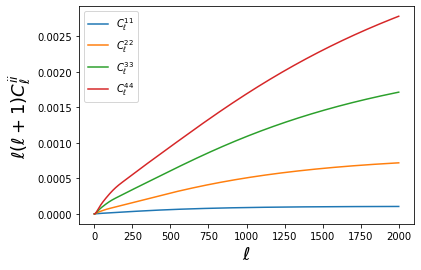

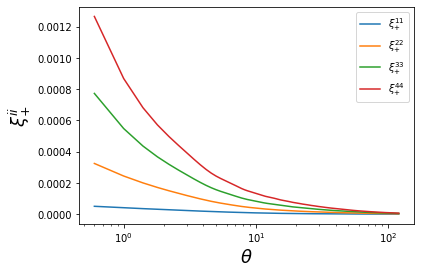

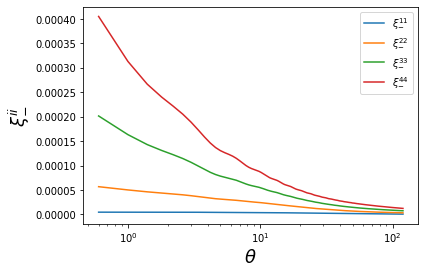

In [12]:
# xip xim pour le bin 4 (auto correlation) et je met l'alignement intrinseque selon 
# la recette de DESY1 et HSCY1

ell = np.arange(1, 2000)
Cl_11 = ccl.angular_cl(C.cosmology, WL_bin1, WL_bin1, ell)
Cl_22 = ccl.angular_cl(C.cosmology, WL_bin2, WL_bin2, ell)
Cl_33 = ccl.angular_cl(C.cosmology, WL_bin3, WL_bin3, ell)
Cl_44 = ccl.angular_cl(C.cosmology, WL_bin4, WL_bin4, ell)

plt.plot(ell, ell*(ell+1)*Cl_11, label='$C_{\ell}^{11}$')
plt.plot(ell, ell*(ell+1)*Cl_22, label='$C_{\ell}^{22}$')
plt.plot(ell, ell*(ell+1)*Cl_33, label='$C_{\ell}^{33}$')
plt.plot(ell, ell*(ell+1)*Cl_44, label='$C_{\ell}^{44}$')
plt.xlabel('$\ell$', fontsize=18)
plt.ylabel('$\ell(\ell+1)C_{\ell}^{ii}$', fontsize=18)
plt.legend()

theta = np.linspace(0.01, 2, 300) #degree
xip_11 = ccl.correlation(C.cosmology, ell, Cl_11, theta, type='GG+')
xim_11 = ccl.correlation(C.cosmology, ell, Cl_11, theta, type='GG-')
xip_22 = ccl.correlation(C.cosmology, ell, Cl_22, theta, type='GG+')
xim_22 = ccl.correlation(C.cosmology, ell, Cl_22, theta, type='GG-')
xip_33 = ccl.correlation(C.cosmology, ell, Cl_33, theta, type='GG+')
xim_33 = ccl.correlation(C.cosmology, ell, Cl_33, theta, type='GG-')
xip_44 = ccl.correlation(C.cosmology, ell, Cl_44, theta, type='GG+')
xim_44 = ccl.correlation(C.cosmology, ell, Cl_44, theta, type='GG-')

plt.figure()
plt.plot(60*theta, xip_11, label='$\\xi_{+}^{11}$')
plt.plot(60*theta, xip_22, label='$\\xi_{+}^{22}$')
plt.plot(60*theta, xip_33, label='$\\xi_{+}^{33}$')
plt.plot(60*theta, xip_44, label='$\\xi_{+}^{44}$')
plt.xscale('log')
plt.xlabel('$\\theta$', fontsize=18)
plt.ylabel('$\\xi_{+}^{ii}$', fontsize=18)
plt.legend()

plt.figure()
plt.plot(60*theta, xim_11, label='$\\xi_{-}^{11}$')
plt.plot(60*theta, xim_22, label='$\\xi_{-}^{22}$')
plt.plot(60*theta, xim_33, label='$\\xi_{-}^{33}$')
plt.plot(60*theta, xim_44, label='$\\xi_{-}^{44}$')
plt.xscale('log')
plt.xlabel('$\\theta$', fontsize=18)
plt.ylabel('$\\xi_{-}^{ii}$', fontsize=18)
plt.legend()

In [ ]:
WL_bin4

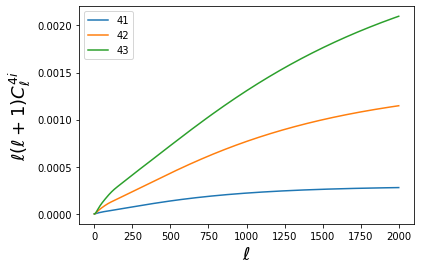

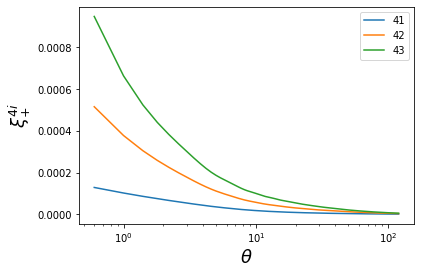

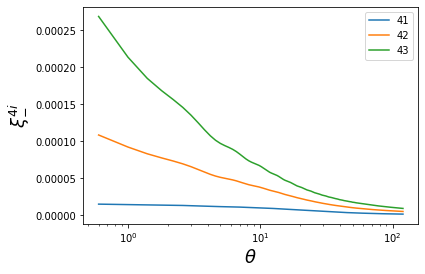

In [13]:
# xip xim pour le bin 4 et 1, 2, 3 (correlation croise)

# WL_bin1 = ccl.WeakLensingTracer(C.cosmology,
#                                 dndz=(redshifts[0], nz[0]),
#                                 has_shear=True,
#                                 ia_bias=None)

ell = np.arange(1, 2000)

Cl_41 = ccl.angular_cl(C.cosmology, WL_bin4, WL_bin1, ell)
Cl_42 = ccl.angular_cl(C.cosmology, WL_bin4, WL_bin2, ell)
Cl_43 = ccl.angular_cl(C.cosmology, WL_bin4, WL_bin3, ell)

plt.plot(ell, ell*(ell+1)*Cl_41, label='41')
plt.plot(ell, ell*(ell+1)*Cl_42, label='42')
plt.plot(ell, ell*(ell+1)*Cl_43, label='43')
plt.xlabel('$\ell$', fontsize=18)
plt.ylabel('$\ell(\ell+1)C_{\ell}^{4i}$', fontsize=18)
plt.legend()

theta = np.linspace(0.01, 2, 300) #degree
xip_41 = ccl.correlation(C.cosmology, ell, Cl_41, theta, type='GG+')
xim_41 = ccl.correlation(C.cosmology, ell, Cl_41, theta, type='GG-')
xip_42 = ccl.correlation(C.cosmology, ell, Cl_42, theta, type='GG+')
xim_42 = ccl.correlation(C.cosmology, ell, Cl_42, theta, type='GG-')
xip_43 = ccl.correlation(C.cosmology, ell, Cl_43, theta, type='GG+')
xim_43 = ccl.correlation(C.cosmology, ell, Cl_43, theta, type='GG-')

plt.figure()
plt.plot(60*theta, xip_41, label='41')
plt.plot(60*theta, xip_42, label='42')
plt.plot(60*theta, xip_43, label='43')
plt.xscale('log')
plt.xlabel('$\\theta$', fontsize=18)
plt.ylabel('$\\xi_{+}^{4i}$', fontsize=18)
plt.legend()


plt.figure()
plt.plot(60*theta, xim_41, label='41')
plt.plot(60*theta, xim_42, label='42')
plt.plot(60*theta, xim_43, label='43')
plt.xscale('log')
plt.xlabel('$\\theta$', fontsize=18)
plt.ylabel('$\\xi_{-}^{4i}$', fontsize=18)
plt.legend()


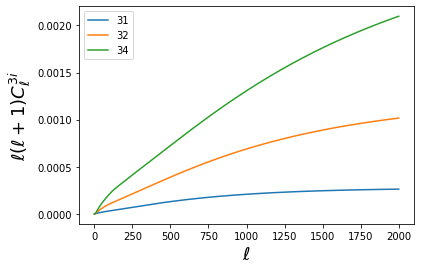

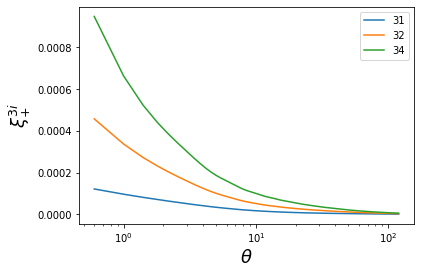

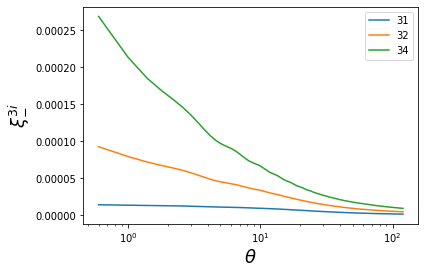

In [14]:
Cl_31 = ccl.angular_cl(C.cosmology, WL_bin3, WL_bin1, ell)
Cl_32 = ccl.angular_cl(C.cosmology, WL_bin3, WL_bin2, ell)
Cl_34 = ccl.angular_cl(C.cosmology, WL_bin3, WL_bin4, ell)

plt.plot(ell, ell*(ell+1)*Cl_31, label='31')
plt.plot(ell, ell*(ell+1)*Cl_32, label='32')
plt.plot(ell, ell*(ell+1)*Cl_34, label='34')
plt.xlabel('$\ell$', fontsize=18)
plt.ylabel('$\ell(\ell+1)C_{\ell}^{3i}$', fontsize=18)
plt.legend()

theta = np.linspace(0.01, 2, 300) #degree
xip_31 = ccl.correlation(C.cosmology, ell, Cl_31, theta, type='GG+')
xim_31 = ccl.correlation(C.cosmology, ell, Cl_31, theta, type='GG-')
xip_32 = ccl.correlation(C.cosmology, ell, Cl_32, theta, type='GG+')
xim_32 = ccl.correlation(C.cosmology, ell, Cl_32, theta, type='GG-')
xip_34 = ccl.correlation(C.cosmology, ell, Cl_34, theta, type='GG+')
xim_34 = ccl.correlation(C.cosmology, ell, Cl_34, theta, type='GG-')

plt.figure()
plt.plot(60*theta, xip_31, label='31')
plt.plot(60*theta, xip_32, label='32')
plt.plot(60*theta, xip_34, label='34')
plt.xscale('log')
plt.xlabel('$\\theta$', fontsize=18)
plt.ylabel('$\\xi_{+}^{3i}$', fontsize=18)
plt.legend()


plt.figure()
plt.plot(60*theta, xim_31, label='31')
plt.plot(60*theta, xim_32, label='32')
plt.plot(60*theta, xim_34, label='34')
plt.xscale('log')
plt.xlabel('$\\theta$', fontsize=18)
plt.ylabel('$\\xi_{-}^{3i}$', fontsize=18)
plt.legend()

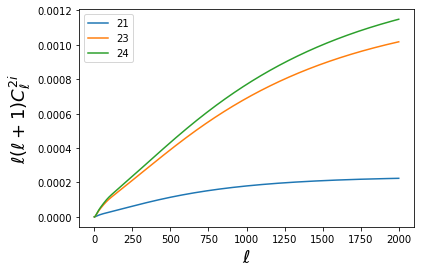

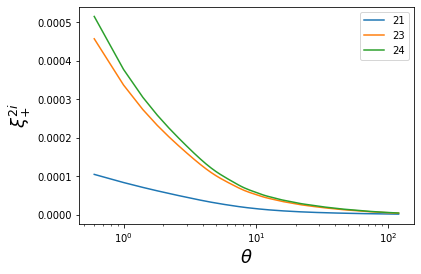

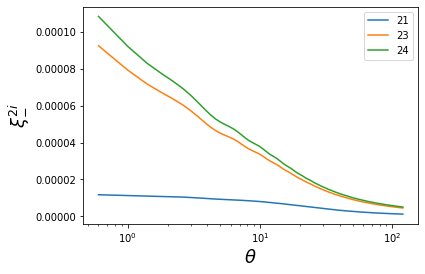

In [15]:
Cl_21 = ccl.angular_cl(C.cosmology, WL_bin2, WL_bin1, ell)
Cl_23 = ccl.angular_cl(C.cosmology, WL_bin2, WL_bin3, ell)
Cl_24 = ccl.angular_cl(C.cosmology, WL_bin2, WL_bin4, ell)

plt.plot(ell, ell*(ell+1)*Cl_21, label='21')
plt.plot(ell, ell*(ell+1)*Cl_23, label='23')
plt.plot(ell, ell*(ell+1)*Cl_24, label='24')
plt.xlabel('$\ell$', fontsize=18)
plt.ylabel('$\ell(\ell+1)C_{\ell}^{2i}$', fontsize=18)
plt.legend()

theta = np.linspace(0.01, 2, 300) #degree
xip_21 = ccl.correlation(C.cosmology, ell, Cl_21, theta, type='GG+')
xim_21 = ccl.correlation(C.cosmology, ell, Cl_21, theta, type='GG-')
xip_23 = ccl.correlation(C.cosmology, ell, Cl_23, theta, type='GG+')
xim_23 = ccl.correlation(C.cosmology, ell, Cl_23, theta, type='GG-')
xip_24 = ccl.correlation(C.cosmology, ell, Cl_24, theta, type='GG+')
xim_24 = ccl.correlation(C.cosmology, ell, Cl_24, theta, type='GG-')

plt.figure()
plt.plot(60*theta, xip_21, label='21')
plt.plot(60*theta, xip_23, label='23')
plt.plot(60*theta, xip_24, label='24')
plt.xscale('log')
plt.xlabel('$\\theta$', fontsize=18)
plt.ylabel('$\\xi_{+}^{2i}$', fontsize=18)
plt.legend()


plt.figure()
plt.plot(60*theta, xim_21, label='21')
plt.plot(60*theta, xim_23, label='23')
plt.plot(60*theta, xim_24, label='24')
plt.xscale('log')
plt.xlabel('$\\theta$', fontsize=18)
plt.ylabel('$\\xi_{-}^{2i}$', fontsize=18)
plt.legend()

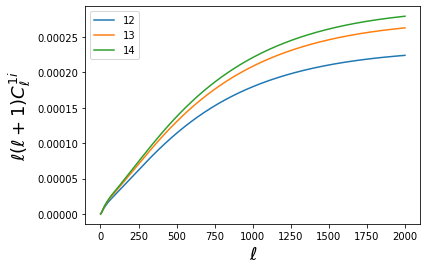

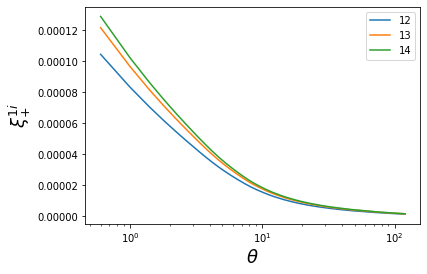

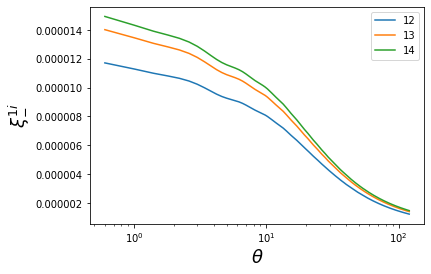

In [16]:
Cl_12 = ccl.angular_cl(C.cosmology, WL_bin1, WL_bin2, ell)
Cl_13 = ccl.angular_cl(C.cosmology, WL_bin1, WL_bin3, ell)
Cl_14 = ccl.angular_cl(C.cosmology, WL_bin1, WL_bin4, ell)

plt.plot(ell, ell*(ell+1)*Cl_12, label='12')
plt.plot(ell, ell*(ell+1)*Cl_13, label='13')
plt.plot(ell, ell*(ell+1)*Cl_14, label='14')
plt.xlabel('$\ell$', fontsize=18)
plt.ylabel('$\ell(\ell+1)C_{\ell}^{1i}$', fontsize=18)
plt.legend()

theta = np.linspace(0.01, 2, 300) #degree
xip_12 = ccl.correlation(C.cosmology, ell, Cl_12, theta, type='GG+')
xim_12 = ccl.correlation(C.cosmology, ell, Cl_12, theta, type='GG-')
xip_13 = ccl.correlation(C.cosmology, ell, Cl_13, theta, type='GG+')
xim_13 = ccl.correlation(C.cosmology, ell, Cl_13, theta, type='GG-')
xip_14 = ccl.correlation(C.cosmology, ell, Cl_14, theta, type='GG+')
xim_14 = ccl.correlation(C.cosmology, ell, Cl_14, theta, type='GG-')

plt.figure()
plt.plot(60*theta, xip_12, label='12')
plt.plot(60*theta, xip_13, label='13')
plt.plot(60*theta, xip_14, label='14')
plt.xscale('log')
plt.xlabel('$\\theta$', fontsize=18)
plt.ylabel('$\\xi_{+}^{1i}$', fontsize=18)
plt.legend()


plt.figure()
plt.plot(60*theta, xim_12, label='12')
plt.plot(60*theta, xim_13, label='13')
plt.plot(60*theta, xim_14, label='14')
plt.xscale('log')
plt.xlabel('$\\theta$', fontsize=18)
plt.ylabel('$\\xi_{-}^{1i}$', fontsize=18)
plt.legend()

[0.01       0.01321621 0.01746681 0.0230845  0.03050896 0.04032127
 0.05328943 0.07042841 0.09307965 0.12301599 0.16258049 0.21486974
 0.2839763  0.37530897 0.49601611 0.65554518 0.8663821  1.14502854
 1.51329346 2.        ]
[1.26497980e-03 1.08198996e-03 8.35141989e-04 6.85813864e-04
 5.71411419e-04 4.53031465e-04 3.58824835e-04 2.83008319e-04
 2.24000639e-04 1.73857949e-04 1.36477365e-04 1.06419545e-04
 8.43355014e-05 6.48428212e-05 4.94962991e-05 3.64792684e-05
 2.59927845e-05 1.77515269e-05 1.14639622e-05 7.01201606e-06]
[1.24508444e-03 1.06244922e-03 8.33883646e-04 6.56326898e-04
 5.37946434e-04 3.86342065e-04 2.86361838e-04 1.92324382e-04
 1.75024084e-04 1.50738241e-04 7.73359467e-05 1.00036865e-04
 1.00597934e-04 6.71477904e-05 6.12940958e-05 1.46559103e-05
 6.72242664e-05 4.80827227e-05 2.47727250e-05 2.69657452e-05]


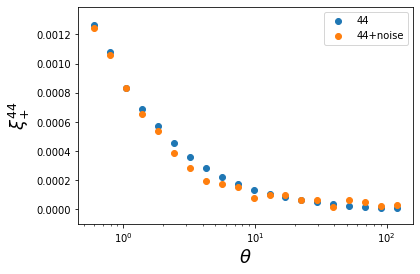

In [42]:
#get samples from xip_44
theta_sample = np.logspace(-2, np.log10(2), 20)
xip_44_sample = ccl.correlation(C.cosmology, ell, Cl_44, theta_sample, type='GG+')
print(theta_sample)
print(xip_44_sample)

#add noise
noise = st.norm.rvs(0, 5e-5, size=len(xip_44_sample), random_state=1369)
noisy_44_sample = xip_44_sample + noise

print(noisy_44_sample)


plt.figure()
plt.scatter(60*theta_sample, xip_44_sample, label='44')
plt.scatter(60*theta_sample, noisy_44_sample, label='44+noise')
plt.xscale('log')
plt.xlabel('$\\theta$', fontsize=18)
plt.ylabel('$\\xi_{+}^{44}$', fontsize=18)
plt.ylim(-0.0001, np.max(xip_44_sample)+0.1*np.max(xip_44_sample))
plt.legend()

In [135]:
def xi_pm_ij(theta, Om_ch2, AS, bin_i=1, bin_j=1, sign='+'):
    """
    Currently can fit for Om_ch2, AS
    bin_i, bin_j, and sign must be passed through the cost function: is
    there a better way to generalize this?
    """
    
    #set up cosmology to be fit
    #currently only fits for Omega_ch2 and AS
    C = Cosmo(Omega_ch2=Om_ch2, Omega_bh2=0.023, AS=AS,
          Omega_nu_h2=1e-3, H0=70, ns=0.97, w0=-1,
          matter_power_spectrum = 'halofit')
        
    #set up redshift and n(z) bins from (global variable) data
    bin_i_idx = int(bin_i - 1)
    bin_j_idx = int(bin_j - 1)
    
    z_i = redshifts[bin_i_idx]
    nz_i = nz_distros[bin_i_idx]
    
    z_j = redshifts[bin_j_idx]
    nz_j = nz_distros[bin_j_idx]
    
    AI_i = intrinsic_al(z_i, A0=1, eta=1, z0=0.62)
    AI_j = intrinsic_al(z_j, A0=1, eta=1, z0=0.62)

    #calculate WL bins
    WL_bin_i = ccl.WeakLensingTracer(C.cosmology,
                                    dndz=(z_i, nz_i),
                                    has_shear=True,
                                    ia_bias=(z_i, AI_i))
    
    WL_bin_j = ccl.WeakLensingTracer(C.cosmology,
                                    dndz=(z_j, nz_j),
                                    has_shear=True,
                                    ia_bias=(z_j, AI_j))
    
    #Calculate angular power spectrum
    ell = np.arange(1, 2000)
    Cl_ij = ccl.angular_cl(C.cosmology, WL_bin_i, WL_bin_j, ell)

    #calculate correlation function xi_plus_ij or xi_minus_ij
    if sign is '+':
        type_str = 'GG+'
    else:
        type_str = 'GG-'
    xi_pm_ij = ccl.correlation(C.cosmology, ell, Cl_ij, theta, type=type_str)
        
    return xi_pm_ij

In [23]:
from iminuit import Minuit
from iminuit.util import describe, make_func_code
from iminuit.cost import Cost

#adapted class from iminuit tutorial
class LeastSquaresNoErr(Cost):
    """
    Generic least-squares cost function without error.
    """

    errordef = Minuit.LEAST_SQUARES # for Minuit to compute errors correctly
    
    def __init__(self, model, x, y, bin_i=None, bin_j=None, sign=None):
        super().__init__(describe(model)[1:3], len(x), verbose=1)
        self.model = model  # model predicts y for given x
        self.x = np.asarray(x)
        self.y = np.asarray(y)
        self.bin_i = bin_i
        self.bin_j = bin_j
        self.sign = sign        
        
    def _call(self, *par):  # we accept a variable number of model parameters
        ym = self.model(self.x, bin_i = self.bin_i, bin_j = self.bin_j, sign=self.sign, *par[0])
        return np.sum((self.y - ym) ** 2)

In [24]:
Cost?

In [25]:
#Testing Least-Squares with no error on Xi_plus_44 correlation "data" with no errors/noise.
lsq_no_err = LeastSquaresNoErr(xi_pm_ij, theta_sample, xip_44_sample, 4, 4, '+')

#input cosmology
#C = Cosmo(Omega_ch2=0.1, Omega_bh2=0.023, AS=4.,
#          Omega_nu_h2=0, H0=70, ns=0.97, w0=-1,
#          matter_power_spectrum = 'halofit')

m = Minuit(lsq_no_err, Om_ch2=0.11, AS=4.1)
m.params

# m.limits = [(0.03, 0.7), (1.5, 6)]
m.limits['Om_ch2'] = (0.03, 0.7)
m.limits['AS'] = (1.5, 6)

m.migrad()

(0.11, 4.1) -> 9.615693205979357e-07
(0.11001100056812463, 4.1) -> 9.630713505436213e-07
(0.10998900008561167, 4.1) -> 9.600614421028891e-07
(0.1101100350947261, 4.1) -> 9.76717007456227e-07
(0.1098900302789028, 4.1) -> 9.465520240283481e-07
(0.11, 4.100410019028989) -> 9.646539352302415e-07
(0.11, 4.09958996905964) -> 9.584858183309847e-07
(0.11, 4.104099651975943) -> 9.926894072683983e-07
(0.11, 4.095899156887319) -> 9.310511002884736e-07
(0.0977203098515072, 3.8887943788536568) -> 1.7326183940844607e-07
(0.10184900785550792, 3.961786085413682) -> 7.0293272584777046e-12
(0.10290203257523899, 3.961786085413682) -> 3.58981844194326e-09
(0.10080272944907666, 3.961786085413682) -> 3.750774686608308e-09
(0.11053326952479277, 3.961786085413682) -> 2.686794294939977e-07
(0.09360366882419376, 3.961786085413682) -> 2.0850185989391915e-07
(0.10184900785550792, 4.003071184397388) -> 1.42027789435516e-08
(0.10184900785550792, 3.9204289124002787) -> 1.3543421452387467e-08
(0.10184900785550792, 4.

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 7.029e-12 (chi2/ndof = 0.0)│              Nfcn = 33               │
│ EDM = 8.93e-13 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Om_ch2 │    0.1    │    0.5    │            │            │  0.03   │   0.7   │       │
│ 1 │ AS     │    4.0    │    3.2    │            │            │   1.5   │    6    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────┐
│        │    Om_ch2        AS │
├────────┼─────────────────────┤
│ Om_ch2 │  5.83e+04 -1.17e+06 │
│     AS │ -1.17e+06  2.36e+07 │
└────────┴─────────────────────┘

In [26]:
print(m.valid, m.accurate)

True False


(0.03, 3.961786085413682) -> 4.62587512402341e-06
(0.03474747474747475, 3.961786085413682) -> 4.523948758175375e-06
(0.03949494949494949, 3.961786085413682) -> 4.376941280606442e-06
(0.044242424242424236, 3.961786085413682) -> 4.177666361215427e-06
(0.048989898989898986, 3.961786085413682) -> 3.922231044756723e-06
(0.053737373737373736, 3.961786085413682) -> 3.6099955173371254e-06
(0.05848484848484848, 3.961786085413682) -> 3.2441659453536378e-06
(0.06323232323232322, 3.961786085413682) -> 2.8320743646695077e-06
(0.06797979797979797, 3.961786085413682) -> 2.3853063140411104e-06
(0.07272727272727272, 3.961786085413682) -> 1.9198271652701103e-06
(0.07747474747474747, 3.961786085413682) -> 1.455445464592622e-06
(0.08222222222222221, 3.961786085413682) -> 1.0150987169080911e-06
(0.08696969696969696, 3.961786085413682) -> 6.238687036779561e-07
(0.09171717171717171, 3.961786085413682) -> 3.0762485109130096e-07
(0.09646464646464645, 3.961786085413682) -> 9.204529822150949e-08
(0.1012121212121

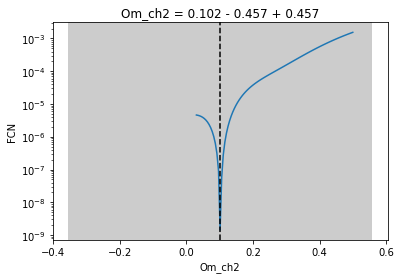

In [27]:
m.draw_profile('Om_ch2', bound=(0.03, 0.5))
plt.yscale('log')

(0.10184900785550792, 1.5) -> 4.4939063199040645e-06
(0.10184900785550792, 1.5454545454545454) -> 4.475323699075715e-06
(0.10184900785550792, 1.5909090909090908) -> 4.455528458753759e-06
(0.10184900785550792, 1.6363636363636362) -> 4.434439728257399e-06
(0.10184900785550792, 1.6818181818181819) -> 4.411971393332046e-06
(0.10184900785550792, 1.7272727272727273) -> 4.3880336180695684e-06
(0.10184900785550792, 1.7727272727272727) -> 4.362534077645691e-06
(0.10184900785550792, 1.8181818181818181) -> 4.335371565429996e-06
(0.10184900785550792, 1.8636363636363638) -> 4.306438006557623e-06
(0.10184900785550792, 1.9090909090909092) -> 4.275624782246689e-06
(0.10184900785550792, 1.9545454545454546) -> 4.242812154610443e-06
(0.10184900785550792, 2.0) -> 4.207881480462906e-06
(0.10184900785550792, 2.0454545454545454) -> 4.1707017146663005e-06
(0.10184900785550792, 2.090909090909091) -> 4.131135751542139e-06
(0.10184900785550792, 2.1363636363636362) -> 4.089046275931639e-06
(0.10184900785550792, 2

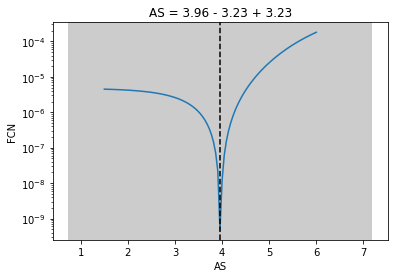

In [28]:
m.draw_profile('AS', bound=(1.5, 6))
plt.yscale('log')

(0.03, 3.0) -> 4.740489617620428e-06
(0.03, 3.2222222222222223) -> 4.725763834507218e-06
(0.03, 3.4444444444444446) -> 4.707110982307385e-06
(0.03, 3.6666666666666665) -> 4.680201403471086e-06
(0.03, 3.888888888888889) -> 4.6417155733623484e-06
(0.03, 4.111111111111111) -> 4.587169255948435e-06
(0.03, 4.333333333333333) -> 4.509240031019915e-06
(0.03, 4.555555555555555) -> 4.396885698011186e-06
(0.03, 4.777777777777778) -> 4.234720904688425e-06
(0.03, 5.0) -> 4.002341692030016e-06
(0.048888888888888885, 3.0) -> 4.578680131918912e-06
(0.048888888888888885, 3.2222222222222223) -> 4.500236282343495e-06
(0.048888888888888885, 3.4444444444444446) -> 4.389796705585424e-06
(0.048888888888888885, 3.6666666666666665) -> 4.234326688770254e-06
(0.048888888888888885, 3.888888888888889) -> 4.016689991446342e-06
(0.048888888888888885, 4.111111111111111) -> 3.7156045211487867e-06
(0.048888888888888885, 4.333333333333333) -> 3.3072250137666587e-06
(0.048888888888888885, 4.555555555555555) -> 2.7701781

/home/yve/anaconda3/lib/python3.7/site-packages/iminuit/minuit.py:1333: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(vx, vy, vz, v)


ValueError: Specified levels [1.0, 2.0, 3.0, 4.0] don't match available levels [0.0]

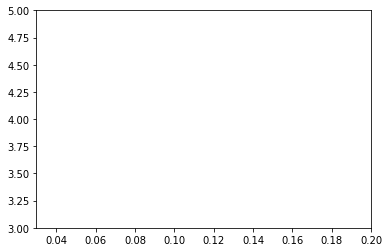

In [47]:
#plot Om_ch2, AS contour plot
x, y = 'Om_ch2', 'AS'

m.draw_contour(x, y, size=10, bound=[[0.03,0.2],[3.,5.]])
plt.yscale('log')

#The below fails because of the very small cost function values.
#draw_contour assumes there will be contours for cost function values of 1,2,3, and 4. 

In [50]:
#create dictionary of N data points from each xi_plus and xi_minus function
N = 20
ell = np.arange(1, 2000)
theta_sample = np.logspace(-2, np.log10(2), N)

data_dict = {}
noisy_data_dict = {}
sigma_dict = {}

for i in range(4):
    for j in range(i,4,1):
        pair_str = str(i+1)+str(j+1)
        #Cl_str = 'Cl_'+pair_str
        xip_str = 'xip_'+pair_str
        xim_str = 'xim_'+pair_str
        
        xi_p_ij = xi_pm_ij(theta_sample, 0.1, 4, i+1, j+1, '+')
        xi_m_ij = xi_pm_ij(theta_sample, 0.1, 4, i+1, j+1, '-')
        
        data_dict[xip_str] = xi_p_ij
        data_dict[xim_str] = xi_m_ij
        
        #using the same sigma for all data points in a sample:
        #10% of the middle data point value
        sigma_p = 0.1 * xi_p_ij[int(N/2)]
        sigma_m = 0.1 * xi_m_ij[int(N/2)]
        
        sigma_dict[xip_str] = sigma_p
        sigma_dict[xim_str] = sigma_m
        
        noise_p = st.norm.rvs(0, sigma_p, size=N, random_state=1369)
        noise_m = st.norm.rvs(0, sigma_m, size=N, random_state=1369)

        noisy_data_dict[xip_str] = xi_p_ij + noise_p
        noisy_data_dict[xim_str] = xi_m_ij + noise_m

print(data_dict)
print(sigma_dict)
print(noisy_data_dict)

{'xip_11': array([5.07946448e-05, 4.59655201e-05, 4.06709049e-05, 3.59331291e-05,
       3.13944279e-05, 2.68559857e-05, 2.25463446e-05, 1.85042762e-05,
       1.48152645e-05, 1.15462967e-05, 8.83313048e-06, 6.68601507e-06,
       5.05857596e-06, 3.83520784e-06, 2.93717257e-06, 2.26309553e-06,
       1.74546012e-06, 1.33582559e-06, 1.00423827e-06, 7.34907837e-07]), 'xim_11': array([4.64103115e-06, 5.26875321e-06, 4.67897363e-06, 4.60718361e-06,
       4.65801374e-06, 4.49402919e-06, 4.40592349e-06, 4.31599179e-06,
       4.23316478e-06, 4.09635971e-06, 3.90936089e-06, 3.61136239e-06,
       3.21655954e-06, 2.75089222e-06, 2.27508597e-06, 1.82374356e-06,
       1.43028320e-06, 1.10828456e-06, 8.56603323e-07, 6.66206025e-07]), 'xip_12': array([1.04589811e-04, 9.36040949e-05, 8.15023689e-05, 7.10808600e-05,
       6.13378877e-05, 5.16997920e-05, 4.27565742e-05, 3.45601211e-05,
       2.72697373e-05, 2.09685599e-05, 1.59126796e-05, 1.20334794e-05,
       9.16607780e-06, 7.01532288e-06, 5.4

In [92]:
#joint fit all 1-4 bin combinations using data with no errors
            
lsqne_tot = None
for i in range(4):
    for j in range(i,4,1):
        pair_str = str(i+1)+str(j+1)
        xip_str = 'xip_'+pair_str
        xim_str = 'xim_'+pair_str
        lsqne_ij = (LeastSquaresNoErr(xi_pm_ij, theta_sample, data_dict[xip_str], i+1, j+1, '+')
                   +LeastSquaresNoErr(xi_pm_ij, theta_sample, data_dict[xim_str], i+1, j+1, '-'))
        
        if lsqne_tot is not None:
            lsqne_tot += lsqne_ij
        else:
            lsqne_tot = lsqne_ij

m2 = Minuit(lsqne_tot, Om_ch2=0.11, AS=4.1)

m2.limits['Om_ch2'] = (0.03, 0.7)
m2.limits['AS'] = (1.5, 6)

m2.migrad()

(0.11, 4.1) -> 2.4366803334477e-06
(0.11001100056812463, 4.1) -> 2.440496537251404e-06
(0.10998900008561167, 4.1) -> 2.4328557790056343e-06
(0.1101100350947261, 4.1) -> 2.4751049079600614e-06
(0.1098900302789028, 4.1) -> 2.3985892875086937e-06
(0.11, 4.100410019028989) -> 2.444232759511281e-06
(0.11, 4.09958996905964) -> 2.429137092833592e-06
(0.11, 4.104099651975943) -> 2.5128437751043206e-06
(0.11, 4.095899156887319) -> 2.361928026624145e-06
(0.09781908547869345, 3.8794004286310244) -> 4.80925080769147e-07
(0.10196754986306683, 3.956599384530183) -> 1.941494939903412e-10
(0.1030213345029923, 3.956599384530183) -> 8.502201414773128e-09
(0.10092050849741965, 3.956599384530183) -> 1.1245128199171733e-08
(0.1072630420385232, 3.956599384530183) -> 2.490021819205446e-07
(0.09683813148016085, 3.956599384530183) -> 2.2818831258780232e-07
(0.10196754986306683, 3.997894300421942) -> 3.269022891469406e-08
(0.10196754986306683, 3.915234159722015) -> 3.612733609398241e-08
(0.10196754986306683, 4.

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1.941e-10 (chi2/ndof = 0.0)│              Nfcn = 33               │
│ EDM = 1.41e-10 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Om_ch2 │    0.1    │    0.5    │            │            │  0.03   │   0.7   │       │
│ 1 │ AS     │     4     │     3     │            │            │   1.5   │    6    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────┐
│        │    Om_ch2        AS │
├────────┼─────────────────────┤
│ Om_ch2 │  2.46e+04 -5.13e+05 │
│     AS │ -5.13e+05  1.07e+07 │
└────────┴─────────────────────┘

In [172]:
class LeastSquares(Cost):
    """
    Generic least-squares cost function tailored for CCL shear-shear correlation function.
    """

    errordef = Minuit.LEAST_SQUARES # for Minuit to compute errors correctly
    
    def __init__(self, model, x, y, yerr):
        super().__init__(describe(model)[1:], len(x), verbose=1)
        self.model = model  # model predicts y for given x
        self.x = np.asarray(x)
        self.y = np.asarray(y)
        if len(y)==1:
            self.yerr = yerr * np.ones_like(y)
        else:
            self.yerr = y
    
    #overload __init__ for CCL model function
    def __init__(self, model, x, y, yerr, bin_i=None, bin_j=None, sign=None):
        super().__init__(describe(model)[1:3], len(x), verbose=1)
        self.model = model
        self.x = np.asarray(x)
        self.y = np.asarray(y)
        if len(y)==1:
            self.yerr = yerr * np.ones_like(y)
        else:
            self.yerr = y        
        self.bin_i = bin_i
        self.bin_j = bin_j
        self.sign = sign
        
    def _call(self, *par):  # we accept a variable number of model parameters
        ym = self.model(self.x, bin_i = self.bin_i, bin_j = self.bin_j, sign=self.sign, *par[0])
        #ym = self.model(self.x, *par[0])
        return np.sum(((self.y - ym) / self.yerr) ** 2)

[ 3.          5.22222222  7.44444444  9.66666667 11.88888889 14.11111111
 16.33333333 18.55555556 20.77777778 23.        ]
[ 6.22447866  7.27837865  8.47468494  7.32469559 15.17598129 13.20832366
 19.47237374 16.40912429 22.03631631 21.92054464]


<ErrorbarContainer object of 3 artists>

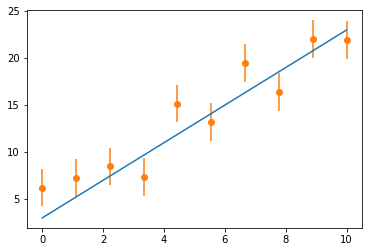

In [79]:
#test with linear data
def linear(x, a, b):
    return a*x + b

x = np.linspace(0,10,10)
a = 2
b = 3
y = st.norm.rvs(a*x+b, 2, random_state=720)

plt.plot(x, linear(x, a, b))
plt.errorbar(x, y, 2, fmt='o')

In [83]:
lsq_lin = LeastSquares(linear, x, y, 2)
mlin = Minuit(lsq_lin, a=1, b=1)

mlin.migrad()

(1.0, 1.0) -> 173.4812584716374
(1.0001, 1.0) -> 173.45811744811095
(0.9999, 1.0) -> 173.50440125442316
(1.000687692827589, 1.0) -> 173.32215486303542
(0.999312307172411, 1.0) -> 173.64044527937904
(1.0, 1.0001) -> 173.47738225154944
(1.0, 0.9999) -> 173.4851347417254
(1.0, 1.001) -> 173.44249852075745
(1.0, 0.999) -> 173.5200234225174
(2.3154344948705816, 8.752490107431907) -> 125.96753288221642
(1.7137813444031984, 5.20665782517712) -> 9.359781079111093
(1.7139489140655941, 5.20665782517712) -> 9.359669611422383
(1.7136137747408027, 5.20665782517712) -> 9.359897486727977
(1.7137813444031984, 5.207651799641996) -> 9.359898225753023
(1.7137813444031984, 5.205663850712244) -> 9.35966887239535
(1.7176577475425154, 5.183651451153047) -> 9.354906520883288
(1.7331633600997836, 5.091625955056751) -> 9.343717471556914
(1.7384603515214463, 5.060188418384402) -> 9.342941708623536
(1.738627784946517, 5.060188418384402) -> 9.342944174572999
(1.7382929180963755, 5.060188418384402) -> 9.34294417457

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.343 (chi2/ndof = 1.2)    │              Nfcn = 32               │
│ EDM = 9.51e-24 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.74    │   0.20    │            │            │         │         │       │
│ 1 │ b    │    5.1    │    1.2    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────┐
│   │      a      b │
├───┼───────────────┤
│ a │ 0.0393 -0.196 │
│ b │ -0.196   1.38 │
└───┴───────────────┘

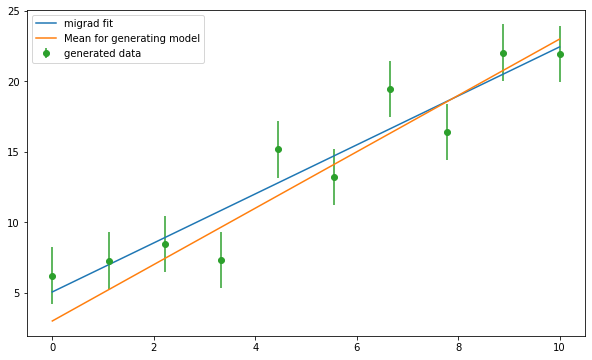

In [114]:
plt.figure(figsize=(10,6))
plt.plot(x, linear(x, mlin.values['a'], mlin.values['b']), label='migrad fit')
plt.plot(x, linear(x, a, b), label='Mean for generating model')
plt.errorbar(x, y, 2, fmt='o', label='generated data')
plt.legend()

(1.342113395100168, 5.060188418384402) -> 23.161123594849148
(1.3501204043208, 5.060188418384402) -> 22.608452714388005
(1.3581274135414318, 5.060188418384402) -> 22.067060831487296
(1.3661344227620638, 5.060188418384402) -> 21.536947946147027
(1.3741414319826957, 5.060188418384402) -> 21.018114058367182
(1.3821484412033274, 5.060188418384402) -> 20.510559168147765
(1.3901554504239593, 5.060188418384402) -> 20.014283275488772
(1.3981624596445912, 5.060188418384402) -> 19.52928638039022
(1.406169468865223, 5.060188418384402) -> 19.055568482852088
(1.414176478085855, 5.060188418384402) -> 18.593129582874383
(1.422183487306487, 5.060188418384402) -> 18.141969680457105
(1.4301904965271188, 5.060188418384402) -> 17.702088775600263
(1.4381975057477505, 5.060188418384402) -> 17.273486868303863
(1.4462045149683824, 5.060188418384402) -> 16.85616395856788
(1.4542115241890143, 5.060188418384402) -> 16.450120046392325
(1.4622185334096462, 5.060188418384402) -> 16.055355131777205
(1.47022554263027

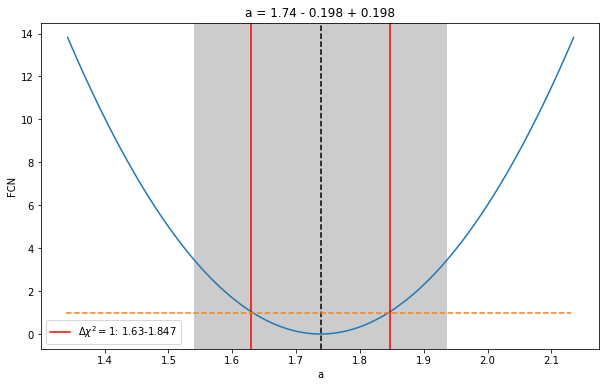

In [133]:
plt.figure(figsize=(10,6))
mlin.draw_profile('a', subtract_min=True)
plt.axvline(1.63, color='r', label=r'$\Delta\chi^2 = 1$: 1.63-1.847')
plt.axvline(1.847, color='r')

plt.plot(np.linspace(1.34,2.13,2), np.ones(2), linestyle='--')
plt.legend()

(1.7384603515214463, 2.7091731582041256) -> 23.161123592628947
(1.7384603515214463, 2.7566684159855455) -> 22.608452712256604
(1.7384603515214463, 2.8041636737669653) -> 22.067060829442873
(1.7384603515214463, 2.8516589315483847) -> 21.536947944187773
(1.7384603515214463, 2.8991541893298045) -> 21.01811405649128
(1.7384603515214463, 2.9466494471112243) -> 20.510559166353413
(1.7384603515214463, 2.994144704892644) -> 20.01428327377415
(1.7384603515214463, 3.041639962674064) -> 19.52928637875351
(1.7384603515214463, 3.0891352204554834) -> 19.0555684812915
(1.7384603515214463, 3.136630478236903) -> 18.59312958138809
(1.7384603515214463, 3.184125736018323) -> 18.141969679043314
(1.7384603515214463, 3.2316209937997424) -> 17.702088774257145
(1.7384603515214463, 3.2791162515811623) -> 17.273486867029597
(1.7384603515214463, 3.326611509362582) -> 16.856163957360664
(1.7384603515214463, 3.374106767144002) -> 16.450120045250348
(1.7384603515214463, 3.4216020249254218) -> 16.055355130698647
(1.7

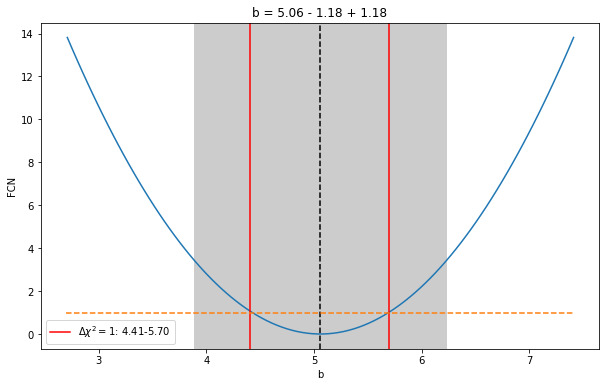

In [134]:
plt.figure(figsize=(10,6))
mlin.draw_profile('b', subtract_min=True)
plt.axvline(4.41, color='r', label=r'$\Delta\chi^2 = 1$: 4.41-5.70')
plt.axvline(5.70, color='r')
plt.plot(np.linspace(2.7,7.41,2), np.ones(2), linestyle='--')
plt.legend()

(1.342113395100168, 2.7091731582041256) -> 60.27474905066536
(1.342113395100168, 3.2316209937997424) -> 49.63894899411339
(1.342113395100168, 3.7540688293953597) -> 40.36790764215412
(1.342113395100168, 4.276516664990977) -> 32.46162499478759
(1.342113395100168, 4.798964500586594) -> 25.92010105201377
(1.342113395100168, 5.321412336182211) -> 20.743335813832694
(1.342113395100168, 5.843860171777828) -> 16.931329280244334
(1.342113395100168, 6.366308007373444) -> 14.484081451248699
(1.342113395100168, 6.888755842969061) -> 13.401592326845787
(1.342113395100168, 7.411203678564679) -> 13.683861907035594
(1.4301904965271188, 2.7091731582041256) -> 49.63894899323629
(1.4301904965271188, 3.2316209937997424) -> 40.153541211835474
(1.4301904965271188, 3.7540688293953597) -> 32.03289213502735
(1.4301904965271188, 4.276516664990977) -> 25.27700176281197
(1.4301904965271188, 4.798964500586594) -> 19.885870095189308
(1.4301904965271188, 5.321412336182211) -> 15.859497132159381
(1.4301904965271188,

(array([1.3421134 , 1.4301905 , 1.5182676 , 1.6063447 , 1.6944218 ,
        1.7824989 , 1.870576  , 1.95865311, 2.04673021, 2.13480731]),
 array([2.70917316, 3.23162099, 3.75406883, 4.27651666, 4.7989645 ,
        5.32141234, 5.84386017, 6.36630801, 6.88875584, 7.41120368]),
 array([[5.08782157e+01, 4.02424157e+01, 3.09713743e+01, 2.30650917e+01,
         1.65235677e+01, 1.13468025e+01, 7.53479596e+00, 5.08754814e+00,
         4.00505901e+00, 4.28732859e+00],
        [4.02424157e+01, 3.07570079e+01, 2.26363588e+01, 1.58804684e+01,
         1.04893368e+01, 6.46296382e+00, 3.80134956e+00, 2.50449400e+00,
         2.57239715e+00, 4.00505901e+00],
        [3.09713743e+01, 2.26363588e+01, 1.56661020e+01, 1.00606039e+01,
         5.81986453e+00, 2.94388384e+00, 1.43266186e+00, 1.28619858e+00,
         2.50449400e+00, 5.08754813e+00],
        [2.30650917e+01, 1.58804684e+01, 1.00606039e+01, 5.60549810e+00,
         2.51515098e+00, 7.89562567e-01, 4.28732859e-01, 1.43266186e+00,
         3.801

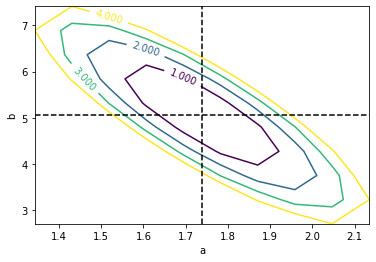

In [139]:
mlin.draw_contour('a', 'b', size=10)

In [121]:
#comparing with the LeastSquares function packaged with minuit
#gets same results as above
from iminuit.cost import LeastSquares as minuitLS

minuit_lsq_lin = minuitLS(x, y, 2, linear, verbose=1)
minuit_mlin = Minuit(minuit_lsq_lin, a=1, b=1)

minuit_mlin.migrad()

(1.0, 1.0) -> 173.48125847163743
(1.0001, 1.0) -> 173.45811744811095
(0.9999, 1.0) -> 173.5044012544231
(1.000687692849809, 1.0) -> 173.32215485789595
(0.9993123071501909, 1.0) -> 173.6404452845239
(1.0, 1.0001) -> 173.47738225154944
(1.0, 0.9999) -> 173.4851347417254
(1.0, 1.001) -> 173.44249852075745
(1.0, 0.999) -> 173.5200234225174
(2.3154344944972056, 8.752490195567516) -> 125.96753570826706
(1.7137813402468067, 5.206657849699689) -> 9.359781084766414
(1.7139489099092242, 5.206657849699689) -> 9.359669617057895
(1.7136137705843892, 5.206657849699689) -> 9.359897492403112
(1.7137813402468067, 5.207651824170487) -> 9.35989823142764
(1.7137813402468067, 5.2056638752288915) -> 9.359668878031421
(1.7176577440604162, 5.183651471696396) -> 9.354906524876863
(1.7331633593148537, 5.091625959683222) -> 9.343717471786032
(1.7384603515213157, 5.060188418384113) -> 9.342941708623531
(1.738627784946348, 5.060188418384113) -> 9.342944174572995
(1.7382929180962834, 5.060188418384113) -> 9.3429441

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.343 (chi2/ndof = 1.2)    │              Nfcn = 32               │
│ EDM = 6.02e-23 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.74    │   0.20    │            │            │         │         │       │
│ 1 │ b    │    5.1    │    1.2    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────┐
│   │      a      b │
├───┼───────────────┤
│ a │ 0.0393 -0.196 │
│ b │ -0.196   1.38 │
└───┴───────────────┘

(1.3421133979289679, 5.060188418384113) -> 23.161123397606293
(1.3501204070924497, 5.060188418384113) -> 22.608452525034302
(1.3581274162559314, 5.060188418384113) -> 22.067060649861734
(1.3661344254194132, 5.060188418384113) -> 21.53694777208858
(1.374141434582895, 5.060188418384113) -> 21.018113891714854
(1.3821484437463767, 5.060188418384113) -> 20.510559008740543
(1.3901554529098585, 5.060188418384113) -> 20.01428312316567
(1.3981624620733404, 5.060188418384113) -> 19.529286234990202
(1.406169471236822, 5.060188418384113) -> 19.055568344214176
(1.4141764804003039, 5.060188418384113) -> 18.59312945083755
(1.4221834895637857, 5.060188418384113) -> 18.14196955486035
(1.4301904987272673, 5.060188418384113) -> 17.702088656282587
(1.4381975078907492, 5.060188418384113) -> 17.273486755104233
(1.446204517054231, 5.060188418384113) -> 16.856163851325288
(1.4542115262177127, 5.060188418384113) -> 16.450119944945794
(1.4622185353811945, 5.060188418384113) -> 16.0553550359657
(1.47022554454467

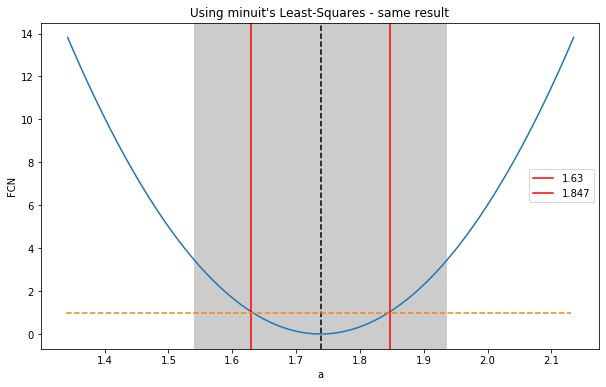

In [127]:
plt.figure(figsize=(10,6))
minuit_mlin.draw_profile('a', subtract_min=True)
plt.axvline(1.63, color='r', label='1.63')
plt.axvline(1.847, color='r', label='1.847')
plt.plot(np.linspace(1.34,2.13,2), np.ones(2), linestyle='--')
plt.title('Using minuit\'s Least-Squares - same result')
plt.legend()

(1.7384603515213157, 2.7091731739716027) -> 23.161123407288713
(1.7384603515213157, 2.756668431434482) -> 22.608452534329455
(1.7384603515213157, 2.804163688897361) -> 22.067060658777496
(1.7384603515213157, 2.8516589463602395) -> 21.536947780632897
(1.7384603515213157, 2.8991542038231186) -> 21.01811389989559
(1.7384603515213157, 2.9466494612859977) -> 20.51055901656563
(1.7384603515213157, 2.9941447187488768) -> 20.014283130642976
(1.7384603515213157, 3.041639976211756) -> 19.529286242127675
(1.7384603515213157, 3.0891352336746345) -> 19.05556835101968
(1.7384603515213157, 3.1366304911375136) -> 18.593129457319016
(1.7384603515213157, 3.1841257486003927) -> 18.141969561025675
(1.7384603515213157, 3.2316210060632717) -> 17.702088662139666
(1.7384603515213157, 3.2791162635261504) -> 17.273486760660983
(1.7384603515213157, 3.3266115209890295) -> 16.856163856589614
(1.7384603515213157, 3.3741067784519085) -> 16.45011994992558
(1.7384603515213157, 3.4216020359147876) -> 16.05535504066887


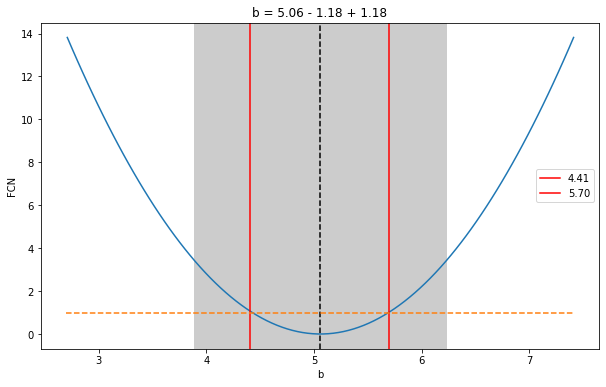

In [126]:
plt.figure(figsize=(10,6))
minuit_mlin.draw_profile('b', subtract_min=True)
plt.axvline(4.41, color='r', label='4.41')
plt.axvline(5.70, color='r', label='5.70')
plt.plot(np.linspace(2.7,7.41,2), np.ones(2), linestyle='--')
plt.legend()

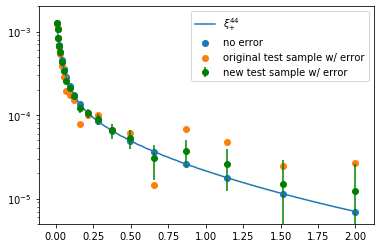

In [168]:
#Testing custom LeastSquares with Xi_44_plus auto-correlation "data" with Gaussian noise
test_str = 'xip_44'

plt.plot(theta, xip_44, label='$\\xi_{+}^{44}$')
plt.scatter(theta_sample, data_dict[test_str], label='no error')
plt.errorbar(theta_sample, noisy_data_dict[test_str], sigma_dict[test_str], 
             fmt='go', label='new test sample w/ error')
plt.scatter(theta_sample, noisy_44_sample, label='original test sample w/ error')
plt.ylim((5e-6,0.002))

plt.yscale('log')
plt.legend()

In [173]:
# lsq_p_44 = LeastSquares(xi_pm_ij, theta_sample, noisy_data_dict[test_str], sigma_dict[test_str], 4, 4, '+')
lsq_p_44 = LeastSquares(xi_pm_ij, theta_sample, noisy_44_sample, 5e-5, 4, 4, '+')

m3 = Minuit(lsq_p_44, Om_ch2=0.11, AS=4.1)

m3.limits['Om_ch2'] = (0.03, 0.7)
m3.limits['AS'] = (1.5, 6)

m3.migrad()

(0.11, 4.1) -> 13.06141624206844
(0.11001100056812463, 4.1) -> 13.070848517858991
(0.10998900008561167, 4.1) -> 13.051997519222864
(0.11000773738177508, 4.1) -> 13.068044797174416
(0.10999226294164585, 4.1) -> 13.054790716689908
(0.11, 4.100410019028989) -> 13.08217155062384
(0.11, 4.09958996905964) -> 13.040713960831813
(0.09386649435936754, 3.938947215827178) -> 3.795953910351041
(0.09622353989741321, 3.9635986994723362) -> 3.9794088826030216
(0.09387258221938785, 3.938947215827178) -> 3.7960241187757355
(0.0938604067589161, 3.938947215827178) -> 3.795884486567048
(0.09387688777589093, 3.938947215827178) -> 3.7960740548619
(0.09385610169937537, 3.938947215827178) -> 3.79583583082109
(0.09386649435936754, 3.9390331101809273) -> 3.7960249685766736
(0.09386649435936754, 3.9388613211961094) -> 3.7958849841234676
(0.09367826660529797, 3.9362812983281454) -> 3.7926669926916854
(0.09347634663159185, 3.933417237702348) -> 3.7913696640791654
(0.0934872491099684, 3.933417237702348) -> 3.791354

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3.712 (chi2/ndof = 0.2)    │              Nfcn = 89               │
│ EDM = 1.05e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Om_ch2 │    0.1    │    0.4    │            │            │  0.03   │   0.7   │       │
│ 1 │ AS     │    3.3    │    3.1    │            │            │   1.5   │    6    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────┐
│        │ Om_ch2     AS │
├────────┼───────────────┤
│ Om_ch2 │ 0.0578 -0.805 │
│     AS │ -0.805   11.3 │
└────────┴───────────────┘

(0.03, 3.2890442773041664) -> 18.560393661855823
(0.03474747474747475, 3.2890442773041664) -> 18.15093932536833
(0.03949494949494949, 3.2890442773041664) -> 17.667816250511695
(0.044242424242424236, 3.2890442773041664) -> 17.115375103708867
(0.048989898989898986, 3.2890442773041664) -> 16.494162234687664
(0.053737373737373736, 3.2890442773041664) -> 15.805121586832028
(0.05848484848484848, 3.2890442773041664) -> 15.051512320466424
(0.06323232323232322, 3.2890442773041664) -> 14.23865973358322
(0.06797979797979797, 3.2890442773041664) -> 13.37380751667975
(0.07272727272727272, 3.2890442773041664) -> 12.46596946304306
(0.07747474747474747, 3.2890442773041664) -> 11.525860711169337
(0.08222222222222221, 3.2890442773041664) -> 10.566123946481532
(0.08696969696969696, 3.2890442773041664) -> 9.601159758925347
(0.09171717171717171, 3.2890442773041664) -> 8.646603428067175
(0.09646464646464645, 3.2890442773041664) -> 7.719948939608599
(0.1012121212121212, 3.2890442773041664) -> 6.8400289623444

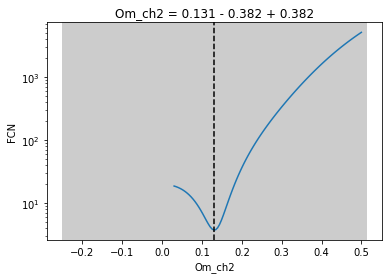

In [177]:
m3.draw_profile('Om_ch2', bound=[0.03,0.5])
plt.yscale('log')

/home/yve/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


(0.13099883954550443, 2.0) -> 13.329893414965543
(0.13099883954550443, 2.0303030303030303) -> 13.13490503566673
(0.13099883954550443, 2.0606060606060606) -> 12.93508433516657
(0.13099883954550443, 2.090909090909091) -> 12.73039546451783
(0.13099883954550443, 2.121212121212121) -> 12.520816487019468
(0.13099883954550443, 2.1515151515151514) -> 12.306331903710955
(0.13099883954550443, 2.1818181818181817) -> 12.086945325220421
(0.13099883954550443, 2.212121212121212) -> 11.862660186166051
(0.13099883954550443, 2.242424242424242) -> 11.633527179784437
(0.13099883954550443, 2.2727272727272725) -> 11.399572082197713
(0.13099883954550443, 2.303030303030303) -> 11.160862280829248
(0.13099883954550443, 2.3333333333333335) -> 10.917486040230996
(0.13099883954550443, 2.3636363636363638) -> 10.66955373497037
(0.13099883954550443, 2.393939393939394) -> 10.417200801368825
(0.13099883954550443, 2.4242424242424243) -> 10.16059559033721
(0.13099883954550443, 2.4545454545454546) -> 9.89992433119754
(0.1

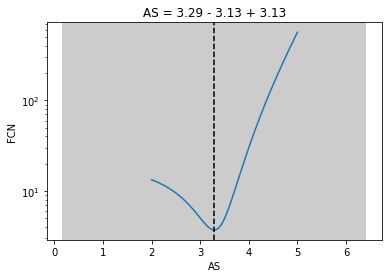

In [179]:
m3.draw_profile('AS', bound=(2, 5))
plt.yscale('log')

(0.05, 1.5) -> 19.359092806979728
(0.05, 1.8333333333333333) -> 19.11721421461602
(0.05, 2.1666666666666665) -> 18.787770829812473
(0.05, 2.5) -> 18.322780615805964
(0.05, 2.833333333333333) -> 17.671280538157994
(0.05, 3.1666666666666665) -> 16.766404490086128
(0.05, 3.5) -> 15.515813219179469
(0.05, 3.833333333333333) -> 13.806616481495096
(0.05, 4.166666666666666) -> 11.535186569834725
(0.05, 4.5) -> 8.711261410990689
(0.07777777777777778, 1.5) -> 18.524865931278338
(0.07777777777777778, 1.8333333333333333) -> 17.94516972577579
(0.07777777777777778, 2.1666666666666665) -> 17.13545779180578
(0.07777777777777778, 2.5) -> 16.010590834785297
(0.07777777777777778, 2.833333333333333) -> 14.463037003043771
(0.07777777777777778, 3.1666666666666665) -> 12.379855831512476
(0.07777777777777778, 3.5) -> 9.706161481521674
(0.07777777777777778, 3.833333333333333) -> 6.641646796853628
(0.07777777777777778, 4.166666666666666) -> 4.16891983184782
(0.07777777777777778, 4.5) -> 5.3397547203990205
(0.1

(array([0.05      , 0.07777778, 0.10555556, 0.13333333, 0.16111111,
        0.18888889, 0.21666667, 0.24444444, 0.27222222, 0.3       ]),
 array([1.5       , 1.83333333, 2.16666667, 2.5       , 2.83333333,
        3.16666667, 3.5       , 3.83333333, 4.16666667, 4.5       ]),
 array([[1.55167532e+01, 1.52748746e+01, 1.49454312e+01, 1.44804410e+01,
         1.38289409e+01, 1.29240648e+01, 1.16734736e+01, 9.96427683e+00,
         7.69284692e+00, 4.86892176e+00],
        [1.46825263e+01, 1.41028301e+01, 1.32931181e+01, 1.21682512e+01,
         1.06206974e+01, 8.53751618e+00, 5.86382183e+00, 2.79930715e+00,
         3.26580181e-01, 1.49741507e+00],
        [1.34657396e+01, 1.24028127e+01, 1.09384967e+01, 8.96087571e+00,
         6.39784490e+00, 3.37025439e+00, 6.00734366e-01, 3.87545670e-01,
         8.71007028e+00, 3.94073933e+01],
        [1.19220416e+01, 1.02856108e+01, 8.10655617e+00, 5.35914819e+00,
         2.30675192e+00, 2.92533093e-02, 1.60531288e+00, 1.45393050e+01,
         5.544

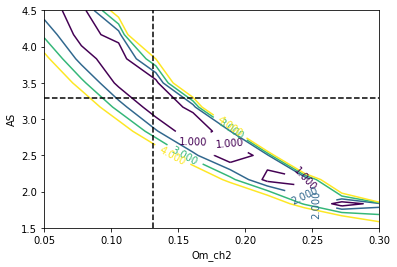

In [184]:
m3.draw_contour('Om_ch2', 'AS', size=10, bound=[[0.05,0.3],[1.5,4.5]])

In [ ]:
#Joint-fitting all auto- and cross-correlation functions - haven't run yet
lsq_tot = None
for i in range(4):
    for j in range(i,4,1):
        pair_str = str(i+1)+str(j+1)
        xip_str = 'xip_'+pair_str
        xim_str = 'xim_'+pair_str        
        lsq_ij = (LeastSquares(xi_pm_ij, theta_sample, data_dict[xip_str], sigma_dict[xip_str], i+1, j+1, '+')
                 +LeastSquares(xi_pm_ij, theta_sample, data_dict[xim_str], sigma_dict[xim_str], i+1, j+1, '-'))
        if lsq_tot is not None:
            lsq_tot += lsq_ij
        else:
            lsq_tot = lsq_ij

m4 = Minuit(lsq_tot, Om_ch2=0.11, AS=4.1)

m4.limits['Om_ch2'] = (0.03, 0.7)
m4.limits['AS'] = (1.5, 6)

m4.migrad()